In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


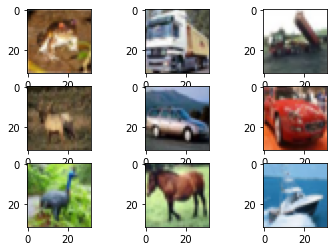

In [2]:
from matplotlib import pyplot
from keras.datasets import cifar10
# load dataset
(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (train_data.shape, train_labels.shape))
print('Test: X=%s, y=%s' % (test_data.shape, test_labels.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(train_data[i])
# show the figure
pyplot.show()

In [3]:
train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

# from PIL import Image

# # Fashion MNIST padding to 32 X 32
# train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
# test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
# train_data_32[:, 2:30, 2:30] = train_data
# test_data_32[:, 2:30, 2:30] = test_data

# # 1channel data reshape
# train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
# test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

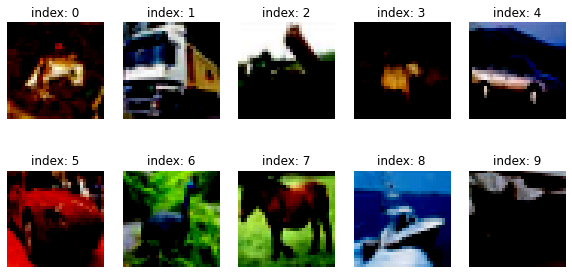

In [4]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

# 이상감지용 데이터셋 구축 (Frog : 6)

In [5]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # Frog : 6
            new_t_labels.append([0])  # Frog을 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [6]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [7]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [8]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [9]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [10]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [11]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [12]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [13]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [15]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


# 모델구성

In [16]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [17]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [18]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

In [19]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

In [20]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

# Loss 함수

In [21]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [22]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [23]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [24]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

In [25]:
@tf.function()
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [26]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
max_epochs = 10
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 26.98496437072754, 	 Total Dis Loss : 0.00020082628179807216
Steps : 200, 	 Total Gen Loss : 23.815673828125, 	 Total Dis Loss : 0.0003987220989074558
Steps : 300, 	 Total Gen Loss : 25.098411560058594, 	 Total Dis Loss : 0.00024319198564626276
Steps : 400, 	 Total Gen Loss : 22.567378997802734, 	 Total Dis Loss : 0.001310881576500833
Steps : 500, 	 Total Gen Loss : 23.004066467285156, 	 Total Dis Loss : 0.0004947387496940792
Steps : 600, 	 Total Gen Loss : 26.43818473815918, 	 Total Dis Loss : 0.00023222102026920766
Steps : 700, 	 Total Gen Loss : 23.94933319091797, 	 Total Dis Loss : 0.000766357290558517
Steps : 800, 	 Total Gen Loss : 24.07225799560547, 	 Total Dis Loss : 0.00123084697406739
Steps : 900, 	 Total Gen Loss : 24.414012908935547, 	 Total Dis Loss : 0.00044507841812446713
Steps : 1000, 	 Total Gen Loss : 26.110240936279297, 	 Total Dis Loss : 0.008089630864560604
Steps : 1100, 	 Total Gen Loss : 21.10123062133789, 	 Total Dis Loss : 0.0007

Steps : 8900, 	 Total Gen Loss : 29.42159080505371, 	 Total Dis Loss : 0.0007299234275706112
Steps : 9000, 	 Total Gen Loss : 26.705810546875, 	 Total Dis Loss : 0.0014931486221030354
Steps : 9100, 	 Total Gen Loss : 31.471420288085938, 	 Total Dis Loss : 0.0004778438596986234
Steps : 9200, 	 Total Gen Loss : 26.446008682250977, 	 Total Dis Loss : 0.002445463091135025
Steps : 9300, 	 Total Gen Loss : 24.227819442749023, 	 Total Dis Loss : 0.006930357776582241
Steps : 9400, 	 Total Gen Loss : 24.39724349975586, 	 Total Dis Loss : 0.0011718787718564272
Steps : 9500, 	 Total Gen Loss : 24.092382431030273, 	 Total Dis Loss : 0.007586537394672632
Steps : 9600, 	 Total Gen Loss : 24.814090728759766, 	 Total Dis Loss : 0.0006414814270101488
Steps : 9700, 	 Total Gen Loss : 27.844453811645508, 	 Total Dis Loss : 0.00239171227440238
Steps : 9800, 	 Total Gen Loss : 22.85378646850586, 	 Total Dis Loss : 0.8231911659240723
Steps : 9900, 	 Total Gen Loss : 28.221120834350586, 	 Total Dis Loss : 0.

Steps : 17500, 	 Total Gen Loss : 26.570283889770508, 	 Total Dis Loss : 0.0003022062301170081
Steps : 17600, 	 Total Gen Loss : 27.45461654663086, 	 Total Dis Loss : 0.0009063560282811522
Steps : 17700, 	 Total Gen Loss : 24.178375244140625, 	 Total Dis Loss : 0.00019276900275144726
Steps : 17800, 	 Total Gen Loss : 25.171457290649414, 	 Total Dis Loss : 0.00017533924255985767
Steps : 17900, 	 Total Gen Loss : 22.218616485595703, 	 Total Dis Loss : 0.00025538852787576616
Steps : 18000, 	 Total Gen Loss : 26.648357391357422, 	 Total Dis Loss : 0.00010539556387811899
Steps : 18100, 	 Total Gen Loss : 25.217987060546875, 	 Total Dis Loss : 0.0002824703697115183
Steps : 18200, 	 Total Gen Loss : 26.1009464263916, 	 Total Dis Loss : 8.863575203577057e-05
Steps : 18300, 	 Total Gen Loss : 24.85849380493164, 	 Total Dis Loss : 0.00027307384880259633
Steps : 18400, 	 Total Gen Loss : 27.179445266723633, 	 Total Dis Loss : 0.00019368412904441357
Steps : 18500, 	 Total Gen Loss : 25.44524765014

Steps : 26100, 	 Total Gen Loss : 24.86672592163086, 	 Total Dis Loss : 0.00018479661957826465
Steps : 26200, 	 Total Gen Loss : 25.139263153076172, 	 Total Dis Loss : 0.00015868639457039535
Steps : 26300, 	 Total Gen Loss : 26.881969451904297, 	 Total Dis Loss : 0.0006082039326429367
Steps : 26400, 	 Total Gen Loss : 27.119510650634766, 	 Total Dis Loss : 0.00029316599830053747
Steps : 26500, 	 Total Gen Loss : 23.685009002685547, 	 Total Dis Loss : 0.0001336713321506977
Steps : 26600, 	 Total Gen Loss : 27.01129150390625, 	 Total Dis Loss : 0.00030966068152338266
Steps : 26700, 	 Total Gen Loss : 23.571922302246094, 	 Total Dis Loss : 0.0003241723752580583
Steps : 26800, 	 Total Gen Loss : 26.523820877075195, 	 Total Dis Loss : 0.0001794453855836764
Steps : 26900, 	 Total Gen Loss : 25.222349166870117, 	 Total Dis Loss : 0.00018213570001535118
Steps : 27000, 	 Total Gen Loss : 28.690521240234375, 	 Total Dis Loss : 0.00012782643898390234
Steps : 27100, 	 Total Gen Loss : 23.349075317

Steps : 34700, 	 Total Gen Loss : 22.584110260009766, 	 Total Dis Loss : 0.0002051343908533454
Steps : 34800, 	 Total Gen Loss : 27.037630081176758, 	 Total Dis Loss : 0.00012378330575302243
Steps : 34900, 	 Total Gen Loss : 26.133363723754883, 	 Total Dis Loss : 8.356880425708368e-05
Steps : 35000, 	 Total Gen Loss : 27.390714645385742, 	 Total Dis Loss : 6.1019800341455266e-05
Steps : 35100, 	 Total Gen Loss : 24.609100341796875, 	 Total Dis Loss : 0.000793533690739423
Steps : 35200, 	 Total Gen Loss : 28.27719497680664, 	 Total Dis Loss : 0.0001251965295523405
Steps : 35300, 	 Total Gen Loss : 24.472875595092773, 	 Total Dis Loss : 0.0003282115503679961
Steps : 35400, 	 Total Gen Loss : 25.124353408813477, 	 Total Dis Loss : 8.229970990214497e-05
Steps : 35500, 	 Total Gen Loss : 25.180238723754883, 	 Total Dis Loss : 0.00012096155114704743
Steps : 35600, 	 Total Gen Loss : 25.820266723632812, 	 Total Dis Loss : 6.0681719332933426e-05
Steps : 35700, 	 Total Gen Loss : 26.22817420959

Steps : 43300, 	 Total Gen Loss : 23.7282657623291, 	 Total Dis Loss : 0.00010995521006407216
Steps : 43400, 	 Total Gen Loss : 25.138835906982422, 	 Total Dis Loss : 0.0005448628216981888
Steps : 43500, 	 Total Gen Loss : 24.161243438720703, 	 Total Dis Loss : 0.00022518362675327808
Steps : 43600, 	 Total Gen Loss : 26.06704330444336, 	 Total Dis Loss : 0.0001443630753783509
Steps : 43700, 	 Total Gen Loss : 26.053102493286133, 	 Total Dis Loss : 7.895463204476982e-05
Steps : 43800, 	 Total Gen Loss : 26.29078483581543, 	 Total Dis Loss : 4.677955075749196e-05
Steps : 43900, 	 Total Gen Loss : 29.562044143676758, 	 Total Dis Loss : 8.33690573927015e-05
Steps : 44000, 	 Total Gen Loss : 24.33040428161621, 	 Total Dis Loss : 0.00027935815160162747
Steps : 44100, 	 Total Gen Loss : 27.337276458740234, 	 Total Dis Loss : 1.4258961527957581e-05
Steps : 44200, 	 Total Gen Loss : 27.455970764160156, 	 Total Dis Loss : 2.9901017114752904e-05
Steps : 44300, 	 Total Gen Loss : 24.99575042724609

Steps : 51900, 	 Total Gen Loss : 23.349502563476562, 	 Total Dis Loss : 0.0009207366965711117
Steps : 52000, 	 Total Gen Loss : 23.930889129638672, 	 Total Dis Loss : 0.000447035621618852
Steps : 52100, 	 Total Gen Loss : 25.30051040649414, 	 Total Dis Loss : 0.00019058959151152521
Steps : 52200, 	 Total Gen Loss : 23.8712158203125, 	 Total Dis Loss : 0.0009763409616425633
Steps : 52300, 	 Total Gen Loss : 26.67156410217285, 	 Total Dis Loss : 0.00053666956955567
Steps : 52400, 	 Total Gen Loss : 30.57076644897461, 	 Total Dis Loss : 0.00018137154984287918
Steps : 52500, 	 Total Gen Loss : 26.358680725097656, 	 Total Dis Loss : 0.0001293654931942001
Steps : 52600, 	 Total Gen Loss : 25.02557373046875, 	 Total Dis Loss : 0.005116583313792944
Steps : 52700, 	 Total Gen Loss : 28.90802764892578, 	 Total Dis Loss : 8.350374264409766e-05
Steps : 52800, 	 Total Gen Loss : 25.579017639160156, 	 Total Dis Loss : 9.814429358812049e-05
Steps : 52900, 	 Total Gen Loss : 23.709304809570312, 	 Tot

In [29]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [30]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


In [31]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


# 시각화

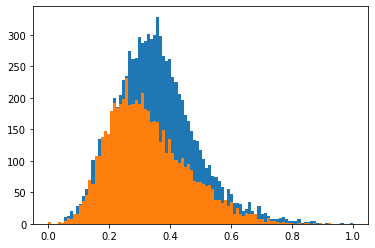

In [32]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.35446084 0.32770965
0.13135536 0.13004197


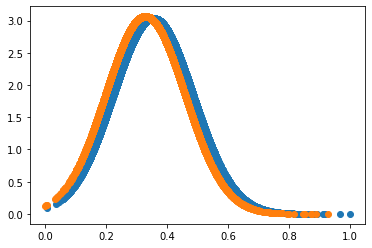

In [33]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))